In [2]:
from PIL import Image
import cv2
import numpy as np
import torch
import gc

In [3]:
%load_ext autoreload
%autoreload 2
!export CUDA_VISIBLE_DEVICES=6
!echo $CUDA_VISIBLE_DEVICES

In [4]:
from scripts.inference_i2mv_sdxl import (
    run_pipeline,
    prepare_pipeline
)

/home/sheongee/miniconda3/envs/mvadapter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
NUMVIEWS = 6
#azimuth_deg = [i*(360/NUMVIEWS) for i in range(NUMVIEWS)]
azimuth_deg = [0, 45, 90, 180, 270, 315]
DEVICE = "cuda:6"

if "pipe" in globals():
	pipe.to("cpu")
	del pipe
	gc.collect()
	torch.cuda.empty_cache()

pipe = prepare_pipeline(
	base_model = "stabilityai/stable-diffusion-xl-base-1.0",
	vae_model = "madebyollin/sdxl-vae-fp16-fix",
	adapter_path = "huanngzh/mv-adapter",
    unet_model = None,
    lora_model = None,
    scheduler = None,
	num_views=NUMVIEWS,
	device=DEVICE,
	dtype=torch.float16,
)


Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

In [50]:
pipe = pipe.to(DEVICE)

In [51]:
def my_custom_callback(pipeline, step, timestep, callback_kwargs):
    """매 타임스텝마다 실행되는 사용자 정의 callback 함수"""
    print(f"Step {step}: Timestep {timestep}")

    latent = callback_kwargs.get("latents", None)
    if latent is None:
        return callback_kwargs
    
    # 이미지를 PIL 형식으로 변환
    def save_image_tensor(latents, path):
        latents = latents / pipeline.vae.config.scaling_factor
        with torch.no_grad():
            image_tensors = pipeline.vae.decode(latents.to(pipeline.device)).sample  # [B, C, H, W]
        images = []
        for img in image_tensors:
            img = (img / 2 + 0.5).clamp(0, 1)  # Normalize to [0, 1]
            img = (img * 255).byte().permute(1, 2, 0).cpu().numpy()  # [H, W, C]로 변환
            img_pil = Image.fromarray(img)
            images.append(img_pil)
        
        # 여러 개의 이미지가 있으면 그리드로 저장
        os.makedirs(path, exist_ok=True)
        if len(images) > 1:
            image_grid = make_image_grid(images, rows=1)  # 기존 코드와 동일한 방식
            img_path = os.path.join(path, f"{step}.png")
            image_grid.save(img_path)
        else:
            img_path = os.path.join(path, f"{step}.png")
            images[0].save(img_path)
    
    SAVE_DIR = "out_0"

    #save_image_tensor(latent, f"{SAVE_DIR}_xt")
    #save_image_tensor(pred_x0, f"{SAVE_DIR}_x0")

    return callback_kwargs

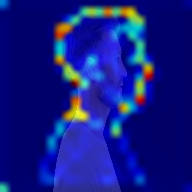

100%|██████████| 50/50 [01:02<00:00,  1.25s/it]

visualize heatmap from query view 1 patch 291


In [ ]:
IMAGE = "assets/demo/i2mv/sideview.png"

images, reference_image = run_pipeline(
    pipe,
    num_views=NUMVIEWS,
    text="A man with short, well-groomed dark hair and a neatly trimmed beard. He has a strong jawline, a straight nose, and a neutral expression. His skin is smooth and light-toned. He is wearing a plain white t-shirt, and his posture is upright.",
    text = "",
    image=IMAGE,
    height=768,
    width=768,
    num_inference_steps=50,
    guidance_scale=3.0,
    seed=21,
    lora_scale=1.0,
    reference_conditioning_scale=1.0,
    negative_prompt="watermark, ugly, deformed, noisy, blurry, low contrast",
    device=DEVICE,
    remove_bg_fn=None,
    azimuth_deg=azimuth_deg,
)

In [11]:
from mvadapter.utils import (
    draw_patches,
    make_image_grid,
    png_to_gif, 
    mask_to_gif
)

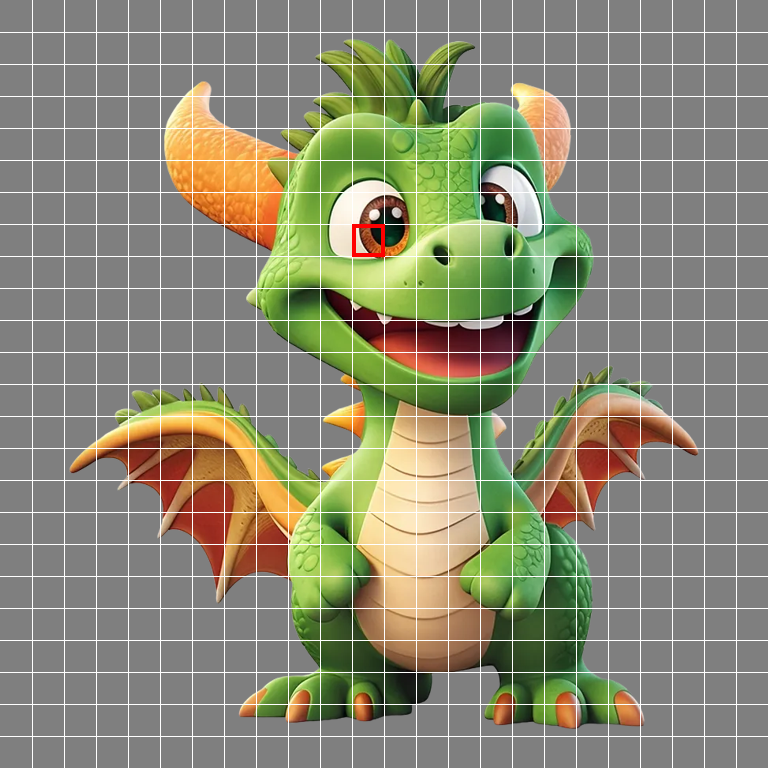

In [45]:
display(draw_patches(reference_image, num_patches=(24, 24), highlight_index=179, line_width=1))

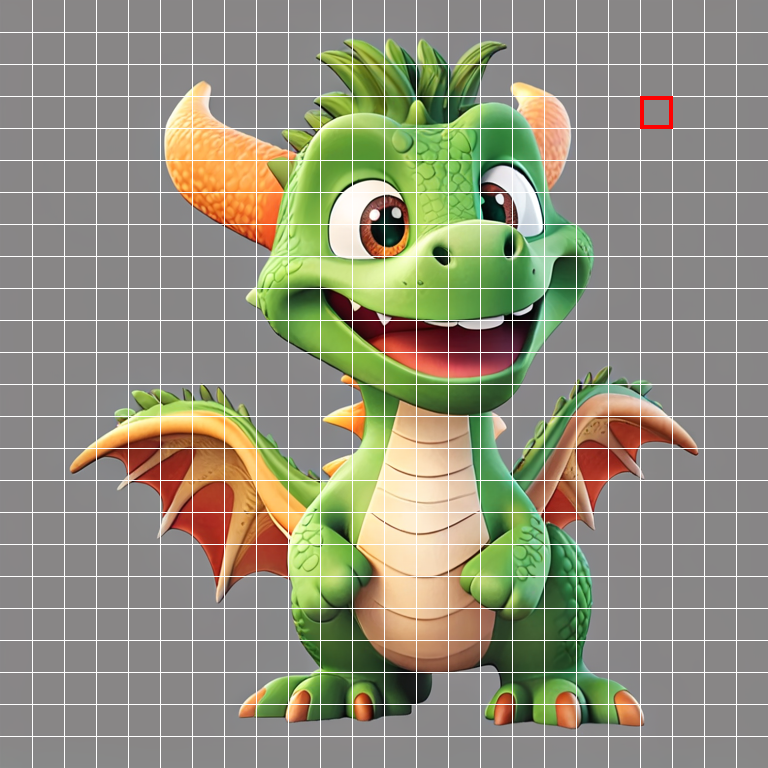

In [55]:
display(draw_patches(images[0], num_patches=(24, 24), highlight_index=92, line_width=1))

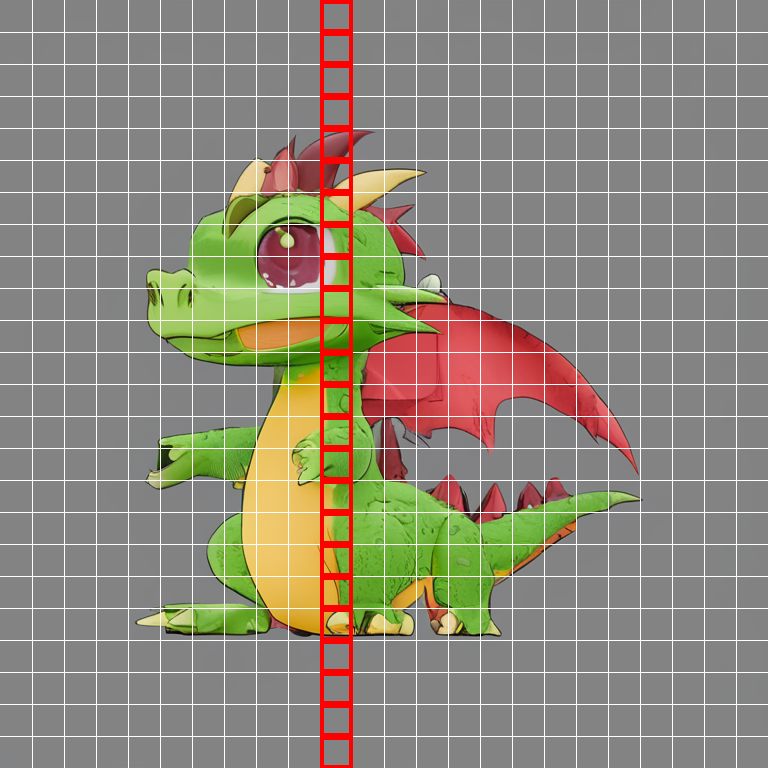

In [19]:
display(draw_patches(images[1], num_patches=(24, 24), highlight_column=10, line_width=1))

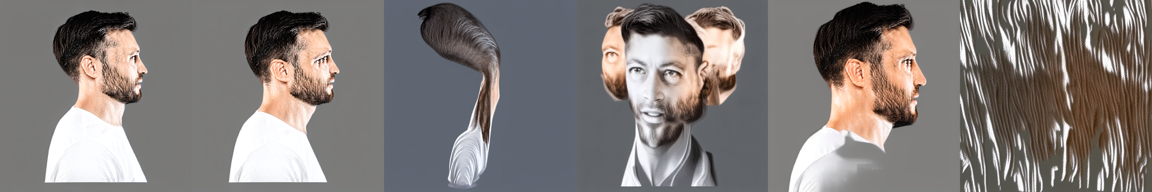

[<PIL.Image.Image image mode=RGB size=768x768 at 0x14C7797122C0>, <PIL.Image.Image image mode=RGB size=768x768 at 0x14C779710640>, <PIL.Image.Image image mode=RGB size=768x768 at 0x14C7797138E0>, <PIL.Image.Image image mode=RGB size=768x768 at 0x14C78E8304C0>, <PIL.Image.Image image mode=RGB size=768x768 at 0x14C78E830280>, <PIL.Image.Image image mode=RGB size=768x768 at 0x14C78E833A30>]


In [95]:
display(make_image_grid(images, rows=1).resize((192*NUMVIEWS, 192)))
print(images)

gif 저장 완료: attn_maps/dino-1-291.gif, filesize:1266.63KB


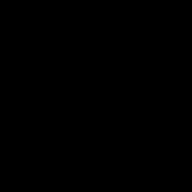

In [ ]:
filename = "dino-1-291"
input_folder = f"attn_maps/{filename}"  # PNG 이미지가 있는 폴더 경로
output_gif = f"attn_maps/{filename}.gif"  # 생성할 GIF 파일 경로
png_to_gif(input_folder, output_gif, duration=100, loop=0)

gif 저장 완료: attn_maps/dino-self-1-10.gif, filesize:2397.35KB


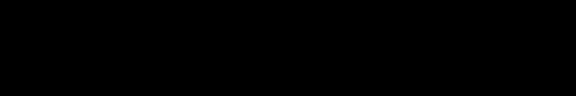

In [20]:
filename = "dino-self-1-10"
input_folder = f"attn_maps/{filename}"  # PNG 이미지가 있는 폴더 경로
output_gif = f"attn_maps/{filename}.gif"  # 생성할 GIF 파일 경로
mask_to_gif(input_folder, output_gif, ref_img=make_image_grid(images, rows=1), duration=100, loop=0)